#Model 1: Skin Disease Multi-label Classification Model

This Model is CNN Multilabel Classification Model with MobileNetV2 Fine-Tuning Model

## Import Libraries and Setup

This cell imports all the necessary libraries required for the machine learning model training pipeline, covering dataset preparation, model training, and evaluation. Below is the purpose of each library and module:

1. **Google Colab Integration**:
   - `drive` from `google.colab`: To connect Google Drive for accessing datasets and storing files.
   - `zipfile`: To extract ZIP files.
   - `os` and `shutil`: For file and folder manipulations in the file system.

2. **Data Preparation**:
   - `csv`: To read and write CSV files.
   - `train_test_split` from `sklearn.model_selection`: To split the dataset into training and testing sets.
   - `ImageDataGenerator` from `tensorflow.keras.preprocessing.image`: For data augmentation and image preprocessing.

3. **Model Development**:
   - `tensorflow` and its submodules:
     - `MobileNetV2`: A pre-trained model used as the base model.
     - `Model`, `Conv2D`, `MaxPooling2D`, etc.: To build and modify the model architecture.
     - `Adam`: An optimizer used for training.
     - `ReduceLROnPlateau` and `EarlyStopping`: Callbacks to control the training process.
     - `regularizers`: For adding regularization to reduce overfitting.

4. **Visualization and Analysis**:
   - `plot_model`: To visualize the model architecture.
   - `Image`: To display images in the notebook.
   - `matplotlib.pyplot` and `seaborn`: To create data visualizations and plots.
   - `classification_report` and `confusion_matrix` from `sklearn.metrics`: To evaluate the model's performance.

5. **Utility Functions**:
   - `sys` and `numpy`: For data manipulation and mathematical operations.
   - `pandas`: For table-based data manipulation and analysis.
   - `load_img`, `img_to_array`: To load and convert images into arrays.

These libraries will be used throughout the pipeline for training a skin disease detection model using MobileNetV2 as the base model.


In [ ]:
from google.colab import drive
import zipfile
import os
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

##Data Preprocessing

###GDrive Mount

### Mount Google Drive

This cell mounts Google Drive to the Colab environment. By using the `drive.mount()` function, files and folders stored in your Google Drive become accessible in the Colab environment under the specified directory (`/content/drive`).

This step is essential for:
- Accessing datasets or other files stored in Google Drive.
- Saving model outputs, logs, or checkpoints directly to Google Drive for persistent storage.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Copy ZIP File from Google Drive

This cell copies a ZIP file from its location in Google Drive to a specified destination directory in the Colab environment. Here's a breakdown:

- `zip_path`: Specifies the path to the ZIP file in Google Drive.
- `destination_path`: Defines the target directory where the ZIP file will be copied.

The command `!cp` is used to execute the copy operation in the Colab environment, allowing seamless access to the ZIP file for further processing, such as extraction or usage within the project workflow.


In [ ]:
# Path to the ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDC.zip'

# Path tujuan di /content
destination_path = '/content/drive/MyDrive/Capstone Project /Machine Learning'

# Salin file dari Google Drive ke /content
!cp "$zip_path" "$destination_path"

cp: '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDC.zip' and '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDC.zip' are the same file


### Extract ZIP File

This cell extracts the contents of a ZIP file to a specified directory. Below is the process:

- `destination_path`: Specifies the path to the ZIP file.
- `extract_path`: Defines the directory where the ZIP file's contents will be extracted.

The code first checks if the ZIP file exists at the specified `destination_path`:
- If the file exists, it uses `zipfile.ZipFile` to extract all contents to the `extract_path`.
- If the file does not exist, it prints an error message indicating the ZIP file is not found.

This step ensures that the dataset or files inside the ZIP are ready to be used in the subsequent stages of the workflow.


In [ ]:
# Path file ZIP
destination_path = '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDC.zip'
extract_path = '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease'

# Periksa apakah file ZIP ada
if os.path.exists(destination_path):
    with zipfile.ZipFile(destination_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"File berhasil diekstrak ke: {extract_path}")
else:
    print(f"File ZIP tidak ditemukan di: {destination_path}")

File berhasil diekstrak ke: /content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease


### Check the Number of Files per Class

This cell verifies the structure of the final dataset and prints the number of files available in each class folder. Below is the process:

- `final_dataset`: Specifies the path to the folder containing the final dataset, organized into subfolders representing different classes.
- The code iterates through the directory using `os.listdir(final_dataset)`:
  - For each subfolder (class), it checks if the path is a directory using `os.path.isdir(class_path)`.
  - If it is a directory, it counts the number of files in that folder using `len(os.listdir(class_path))` and prints the class name along with the file count.

This step is useful to ensure that the dataset is organized correctly and to confirm the distribution of files across different classes.


In [ ]:
# Path ke folder dataset final
final_dataset = '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease'

# Mengecek jumlah file per kelas
print("Jumlah file per kelas di:", final_dataset)
for class_name in os.listdir(final_dataset):
    class_path = os.path.join(final_dataset, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya menghitung folder
        file_count = len(os.listdir(class_path))
        print(f"{class_name}: {file_count} files")

Jumlah file per kelas di: /content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease
Acne: 611 files
Blackhead: 624 files
Darkspot: 664 files
Enlarged Pore: 665 files
Redness: 660 files
Wrinkles: 672 files


### Generate CSV File for Image Labels

This cell creates a CSV file that maps each image file in the dataset to its corresponding label (class). Below is the process:

- `disease_classes`: A list of class names (subfolder names) representing different skin diseases.
- `base_path`: The path to the directory containing the dataset organized into subfolders for each class.
- `output_csv`: The output file path for the generated CSV file.

Steps:
1. Open a new CSV file (`skin_disease_labels.csv`) for writing.
2. Write the header row: `['file', 'label']`.
3. Iterate through each class in `disease_classes`:
   - Construct the path to the folder for the current class.
   - Loop through all image files in the folder.
   - Write the file name and its corresponding label (class name) to the CSV.

At the end of this process, the CSV file serves as a metadata file, linking each image to its class label. This file will be helpful for data preprocessing and model training. A success message is printed upon completion.


In [ ]:
# Daftar kelas (folder)
disease_classes = ['Acne', 'Blackhead', 'Darkspot', 'Enlarged Pore', 'Redness', 'Wrinkles']
base_path = '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease'
# Membuat file CSV untuk mencatat label
output_csv = os.path.join(base_path, 'skin_disease_labels.csv')
with open(output_csv, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['file', 'label'])  # Header

    # Iterasi tiap kelas dan menulis data ke CSV
    for disease in disease_classes:
        disease_folder = os.path.join(base_path, disease)
        for img_file in os.listdir(disease_folder):
            writer.writerow([img_file, disease])
print("Labeling selesai, data disimpan di skin_disease_labels.csv.")

Labeling selesai, data disimpan di skin_disease_labels.csv.


### Split Dataset into Train, Validation, and Test Sets

This cell divides the dataset into three subsets: training, validation, and testing, with an 80-10-10 split ratio for each class. Below is the process:

- **Paths and Classes**:
  - `dataset_path`: The main dataset directory containing subfolders for each class.
  - `train_path`, `val_path`, `test_path`: Paths for the train, validation, and test directories.
  - `disease_classes`: A list of class names (subfolder names) representing different skin diseases.

- **Directory Creation**:
  - Creates the necessary directories for training, validation, and testing subsets, including subdirectories for each class.

- **Dataset Splitting**:
  - For each class:
    1. Lists all images in the class directory.
    2. Splits the images:
       - 80% for training.
       - 10% for validation.
       - 10% for testing.
    3. Moves the images to their respective directories.

- **Split Ratios**:
  - `train_test_split` is used twice:
    - First, to separate the training set (80%) from the remaining 20% (`temp_images`).
    - Second, to split `temp_images` equally into validation and test sets (10% each).

- **Output**:
  - Prints the number of images assigned to each subset for every class.
  - Once the process is complete, it confirms that the dataset has been successfully divided.

This step ensures that the dataset is organized into training, validation, and testing subsets, ready for model training and evaluation.

In [ ]:
# Direktori dataset
dataset_path = '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

# Daftar kelas
disease_classes = ['Acne', 'Blackhead', 'Darkspot', 'Enlarged Pore', 'Redness', 'Wrinkles']

# Membuat direktori train, validation, test
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Split dataset secara proporsional untuk setiap kelas
for disease in disease_classes:
    class_dir = os.path.join(dataset_path, disease)
    images = os.listdir(class_dir)

    # Menghitung proporsi split (80% train, 10% val, 10% test)
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Membuat subdirektori untuk setiap kelas
    train_class_dir = os.path.join(train_path, disease)
    val_class_dir = os.path.join(val_path, disease)
    test_class_dir = os.path.join(test_path, disease)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Memindahkan gambar ke folder yang sesuai
    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(val_class_dir, img))
    for img in test_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

    print(f"Kelas {disease} selesai diproses: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

print("Dataset berhasil dibagi ke train, validation, dan test.")


Kelas Acne selesai diproses: Train=488, Val=61, Test=62
Kelas Blackhead selesai diproses: Train=499, Val=62, Test=63
Kelas Darkspot selesai diproses: Train=531, Val=66, Test=67
Kelas Enlarged Pore selesai diproses: Train=532, Val=66, Test=67
Kelas Redness selesai diproses: Train=528, Val=66, Test=66
Kelas Wrinkles selesai diproses: Train=537, Val=67, Test=68
Dataset berhasil dibagi ke train, validation, dan test.


### Create Data Generators for Training, Validation, and Testing

This cell defines and uses a function, `create_data_generators`, to create data generators for training, validation, and testing datasets. These generators preprocess images and apply augmentations as needed before feeding them into the model.

#### Function Details:
- **`create_data_generators(train_dir, val_dir, test_dir)`**:
  - **Data Augmentation**:
    - `ImageDataGenerator` is used for real-time data augmentation in the training set, including:
      - Rescaling pixel values to `[0, 1]` range (`rescale=1./255`).
      - Random transformations (rotation, shifting, shearing, zooming, flipping) to improve generalization.
  - **Normalization**:
    - Validation and test sets are only rescaled to normalize pixel values, ensuring no augmentation is applied to them.
  - **Data Flow**:
    - The `flow_from_directory` method is used to load images from the dataset directories, resizing them to `(224, 224)` (the input size for the MobileNetV2 model) and organizing them into batches of size 32.
    - The `class_mode='categorical'` specifies that this is a multi-class classification task.

#### Outputs:
- **Training Generator**: Applies augmentation to the training set and prepares batches of normalized images for model training.
- **Validation Generator**: Provides normalized images for validation, used during training to monitor performance on unseen data.
- **Testing Generator**: Provides normalized images for evaluating the final model. The `shuffle=False` ensures that predictions match the order of files in the test set.

#### Usage:
The function is called to create the `train_generator`, `val_generator`, and `test_generator` using the paths to the corresponding datasets. These generators are now ready to be used for model training and evaluation.

#### Output:
A confirmation message, *"Data generators are ready to use."*, is printed to indicate that the generators were successfully created.


In [ ]:
def create_data_generators(train_dir, val_dir, test_dir):
    # Data augmentation untuk training set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Normalisasi untuk validation dan test set
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Generator untuk training set
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Generator untuk validation set
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Generator untuk test set
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# Membuat generator
train_generator, val_generator, test_generator = create_data_generators(
    train_path, val_path, test_path
)

print("Data generators siap digunakan.")


Found 3115 images belonging to 6 classes.
Found 388 images belonging to 6 classes.
Found 393 images belonging to 6 classes.
Data generators siap digunakan.


## Build the Model

### Define and Compile Model

This cell defines the architecture of the model using the functional API in Keras, with MobileNetV2 as the base model. It includes preprocessing layers, fully connected layers, and an output layer suitable for multi-label classification.

#### Model Architecture:

1. **Base Model**:
   - The `MobileNetV2` model is loaded with pre-trained weights from ImageNet (`weights='imagenet'`).
   - The `include_top=False` argument excludes the fully connected layers from the pre-trained model, allowing us to customize the top layers for our task.
   - The input shape is `(224, 224, 3)`, which corresponds to color images of size 224x224.

2. **Input Layer**:
   - Defines the shape of the input images as `(224, 224, 3)`.

3. **Global Average Pooling**:
   - Instead of using a Flatten layer, `GlobalAveragePooling2D()` is used to reduce the feature map dimensions by averaging over each feature map, resulting in a 1D vector.

4. **Fully Connected Layers**:
   - Two `Dense` layers are added, with ReLU activation and L2 regularization to reduce overfitting.
   - `BatchNormalization` is applied after each dense layer to normalize the activations and speed up training.
   - `Dropout` is applied to reduce overfitting:
     - The first `Dropout` layer has a rate of 0.4, and the second one has a rate of 0.3.

5. **Output Layer**:
   - A `Dense` layer with 6 units (one for each disease class) and `sigmoid` activation is used. This configuration is suitable for multi-label classification.

6. **Model Compilation**:
   - The model is compiled with the following:
     - **Optimizer**: `Adam` with a learning rate of 0.0001.
     - **Loss Function**: `binary_crossentropy` (suitable for multi-label classification).
     - **Metric**: Accuracy is used to monitor the model's performance during training.

#### Output:
This cell creates and compiles the model, making it ready for training.


In [ ]:
# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Functional API
input_layer = Input(shape=(224, 224, 3))
x = base_model(input_layer)

# Global Average Pooling layer instead of Flatten
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Adjusted Dropout

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output_layer = Dense(6, activation='sigmoid')(x)

# Define model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Model Summary and Visualization

This cell defines a function `model_summary` that prints the summary of the model and generates a visual representation of the model architecture. Below is the breakdown of its functionality:

#### `model_summary(model)`:

1. **Model Summary**:
   - The `model.summary()` method is called to display a summary of the model architecture, including details of each layer, its output shape, the number of parameters, and other useful information. This summary is printed in the output.

2. **Model Visualization**:
   - The `plot_model` function from Keras is used to generate a graphical visualization of the model architecture:
     - `to_file='model.jpg'`: Saves the plot as a `.jpg` file.
     - `show_shapes=True`: Displays the shape of the output at each layer.
     - `show_dtype=True`: Displays the data type of the outputs.
     - `rankdir='TB'`: Specifies the layout of the plot (top-to-bottom).
     - `dpi=150`: Sets the resolution of the image.
     - `show_layer_activations=True`: Displays the activation functions used in each layer.

3. **Image Display**:
   - The `display(Image(filename='model.jpg'))` function displays the saved model plot image within the notebook.

#### Output:
This function generates two outputs:
- A textual summary of the model architecture.
- A visual plot of the model architecture, displayed as an image.

This step is useful for reviewing the model structure and ensuring that it aligns with the design specifications.


In [ ]:
def model_summary(model):
  print(f"Model Summary:\n{model.summary()}")
  plot_model(
      model,
      to_file='model.jpg',
      show_shapes=True,
      show_dtype=True,
      rankdir='TB',
      dpi=150,
      show_layer_activations=True
  )
  display(Image(filename='model.jpg'))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,078,100 (34.63 MB)

 Trainable params: 3,014,150 (11.50 MB)

 Non-trainable params: 35,648 (139.25 KB)

 Optimizer params: 6,028,302 (23.00 MB)

Model Summary:
None


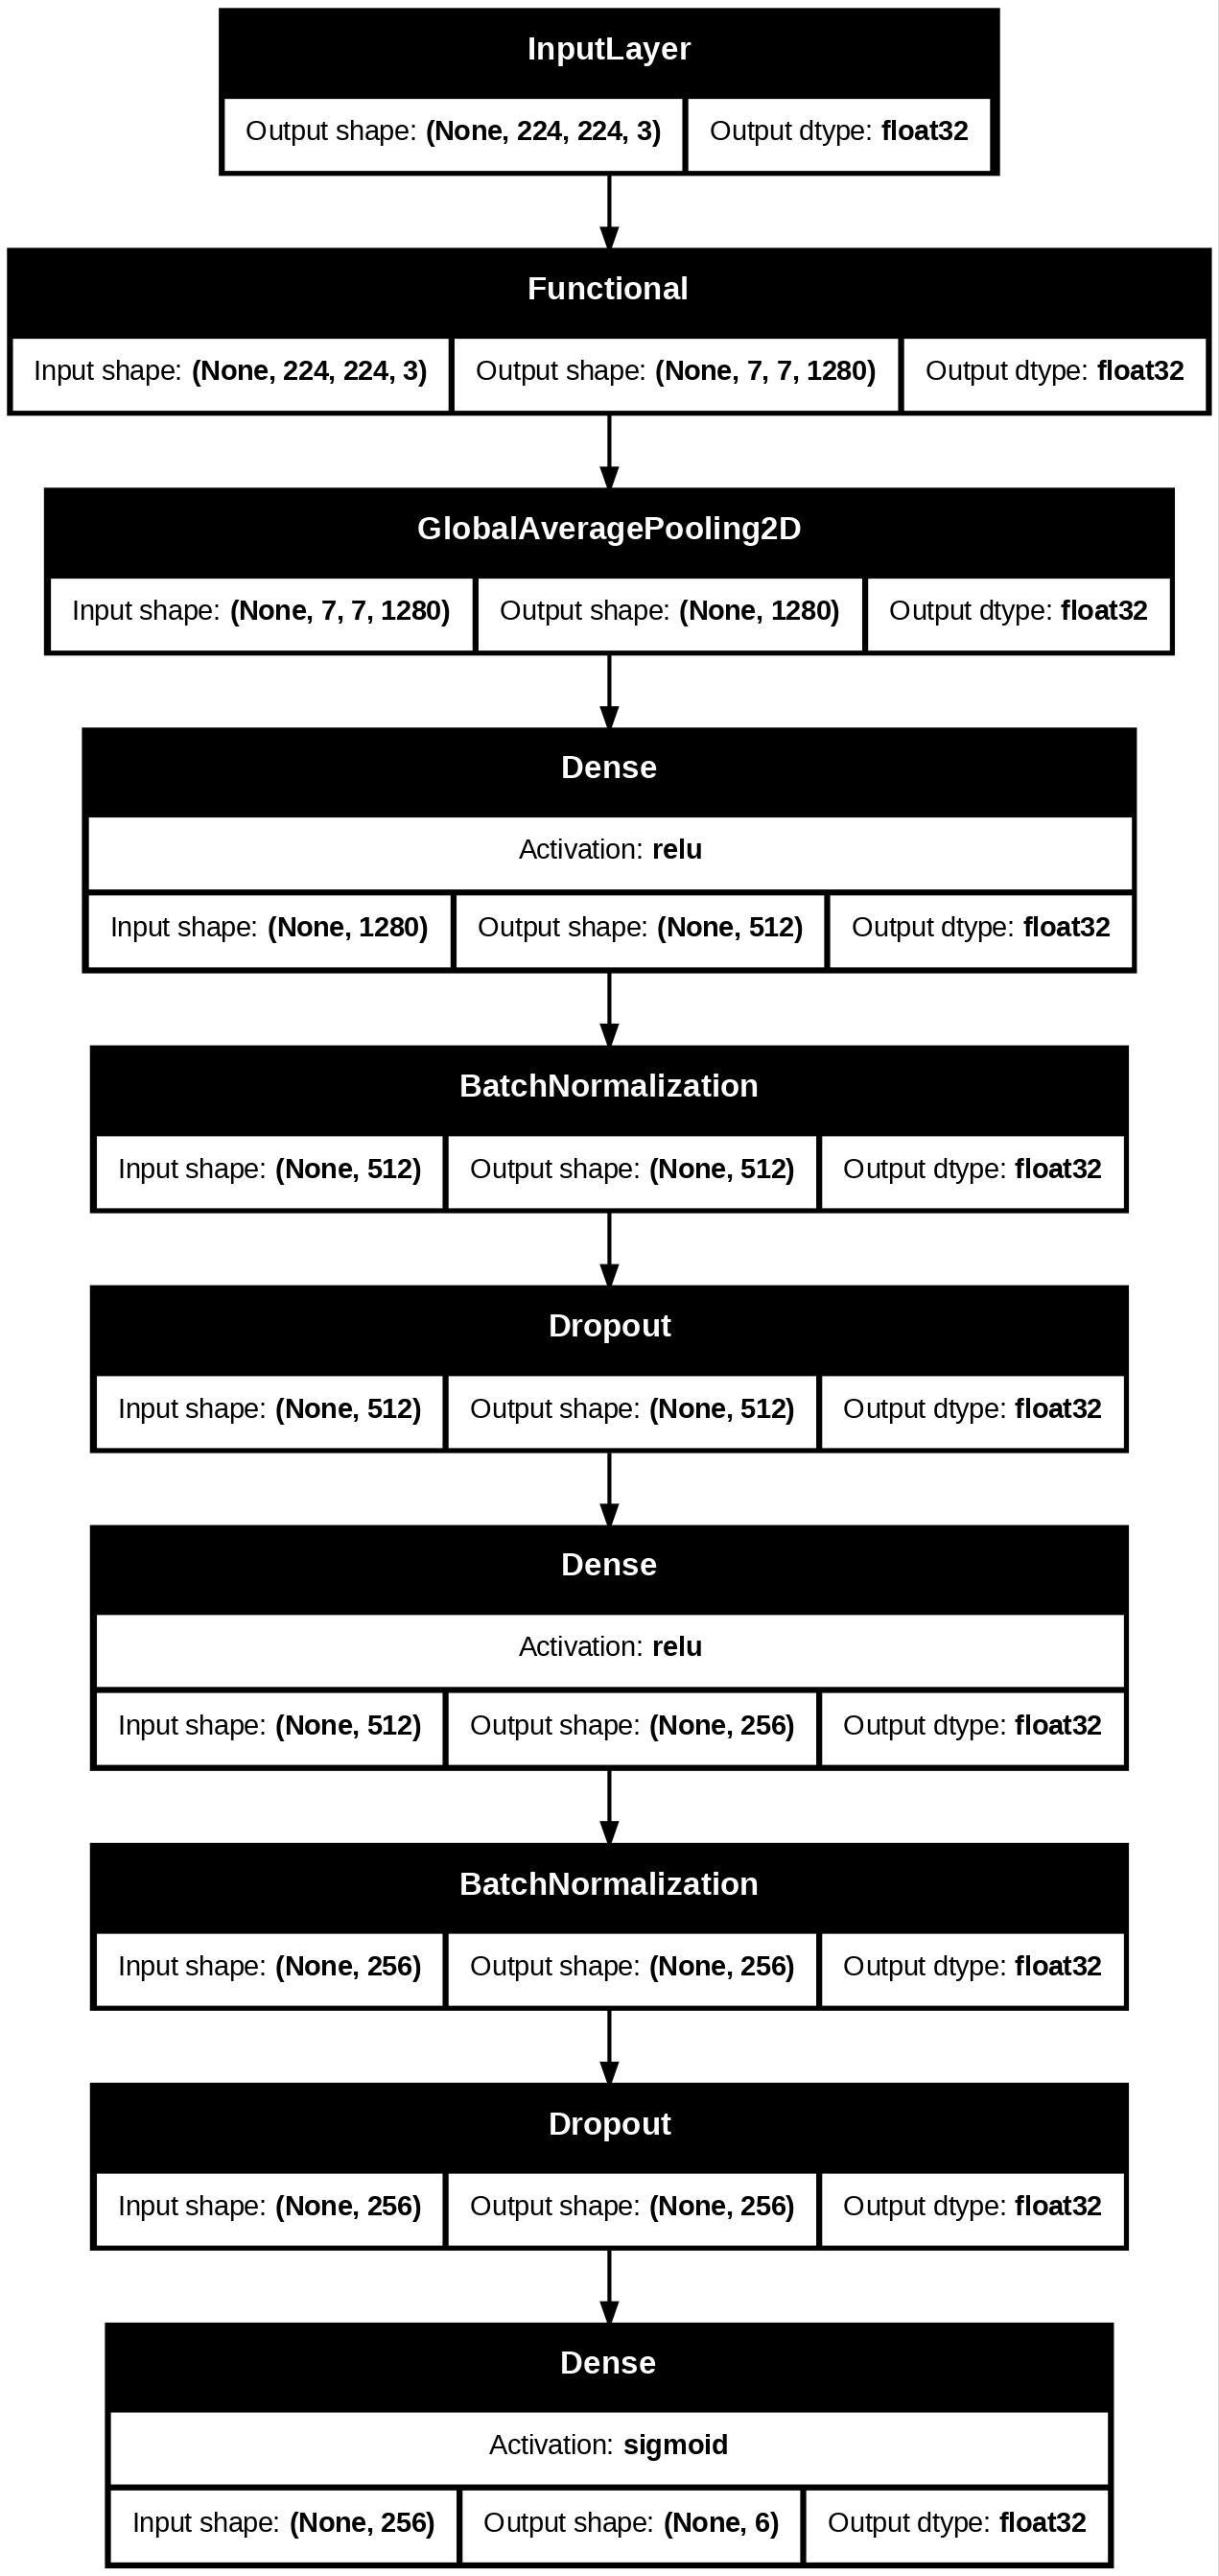

In [ ]:
model_summary(model)

### Fine-Tuning and Callbacks Setup

This cell performs two tasks: unfreezing some layers of the base model for fine-tuning and setting up callbacks for training.

#### 1. **Fine-Tuning**:
   - **Unfreezing Layers**:
     - In transfer learning, it is common to freeze the base model layers to retain the pre-trained weights. However, to adapt the model to the new dataset, some layers are unfrozen to be fine-tuned.
     - The last 20 layers of the `base_model` are set to be trainable using the following code:
       ```python
       for layer in base_model.layers[-20:]:
           layer.trainable = True
       ```
     - This allows the model to update these layers' weights during training, enabling the model to learn more specific features relevant to the new dataset.

#### 2. **Callbacks**:
   - **Reduce Learning Rate on Plateau**:
     - The `ReduceLROnPlateau` callback reduces the learning rate when the validation loss has stopped improving:
       - `monitor='val_loss'`: Tracks the validation loss.
       - `factor=0.2`: Reduces the learning rate by a factor of 0.2.
       - `patience=3`: Waits for 3 epochs with no improvement before reducing the learning rate.
       - `min_lr=1e-6`: Sets the minimum learning rate to 1e-6, preventing it from decreasing further.
   
   - **Early Stopping**:
     - The `EarlyStopping` callback stops training if the validation loss doesn't improve for a specified number of epochs:
       - `monitor='val_loss'`: Tracks the validation loss.
       - `patience=10`: Waits for 10 epochs with no improvement before stopping the training.
       - `restore_best_weights=True`: Restores the model weights from the epoch with the best validation loss.

#### Output:
This cell does not produce direct output but prepares the model and training process for fine-tuning with appropriate callbacks. The callbacks help optimize the training process by preventing overfitting and improving convergence.


In [ ]:
# Unfreeze some layers of the base model (fine-tuning)
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Train the Model

This cell trains the model using the `fit` method, which adjusts the model's weights based on the training data. It also includes the validation set to monitor performance during training and uses callbacks to optimize the process.

### Training Process:
- **Training Data**:
  - The `train_generator` is used to provide the training data in batches. This generator applies real-time data augmentation to the images during training.
  
- **Validation Data**:
  - The `val_generator` is used to provide the validation data in batches. It does not apply data augmentation but only rescaling to the images to ensure the model is validated on unseen data.

- **Epochs**:
  - The model will be trained for up to 50 epochs. This is the maximum number of passes through the entire training dataset.

- **Callbacks**:
  - The `reduce_lr` and `early_stop` callbacks are used to dynamically adjust the learning rate and stop training early if necessary, based on the performance on the validation set.

### Output:
- The `history` object will store the training and validation loss and accuracy for each epoch, which can be used to analyze the model's performance over time.

This step is crucial for training the model and evaluating its performance on the validation set, with mechanisms in place to improve training efficiency and avoid overfitting.


In [ ]:
# Training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.4009 - loss: 11.2614 - val_accuracy: 0.5438 - val_loss: 10.2878 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 112s 894ms/step - accuracy: 0.7744 - loss: 9.8257 - val_accuracy: 0.6057 - val_loss: 9.0979 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 145s 936ms/step - accuracy: 0.8718 - loss: 8.5326 - val_accuracy: 0.6418 - val_loss: 7.9809 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 920ms/step - accuracy: 0.9005 - loss: 7.3394 - val_accuracy: 0.7062 - val_loss: 6.8310 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 892ms/step - accuracy: 0.9121 - loss: 6.2415 - val_accuracy: 0.7577 - val_loss: 5.6968 - learning_rate: 1.0000e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 91s 863ms/step - accuracy: 0.9487 - loss: 5.2197 - val_accuracy: 0.8325 - val_loss: 4.6825 - learning_rate: 1.0000e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 148s 916ms/step - accuracy:

## Evaluate the Model

### Evaluate the Model on the Test Set

This cell evaluates the model’s performance on the test set using the `evaluate` method. It computes the loss and accuracy based on the test data provided by the `test_generator`.

#### Evaluation Process:
- **STEP_SIZE_TEST**:
  - `STEP_SIZE_TEST` is calculated as the total number of test samples (`test_generator.n`) divided by the batch size (`test_generator.batch_size`). This determines how many steps (batches) the model should process to complete the evaluation.
  
- **Resetting the Generator**:
  - `test_generator.reset()` is called to ensure that the generator starts from the beginning before evaluating the model. This is necessary if the generator has already been used for any prior operations.
  
- **Model Evaluation**:
  - The `model.evaluate()` function is used to compute the test loss and test accuracy based on the test data. The number of steps is provided by `steps=STEP_SIZE_TEST`.

#### Output:
- **Test Loss**: The loss value computed on the test set.
- **Test Accuracy**: The accuracy metric computed on the test set.

This step is important for assessing the final model's performance on unseen data, which provides an estimate of how well the model will generalize to new, real-world data.


In [ ]:
# Evaluate on test set
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator, steps=STEP_SIZE_TEST)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.9774 - loss: 0.0503
Test Loss: 0.0358
Test Accuracy: 0.9870


### Plot Training and Validation Accuracy and Loss

This cell generates plots to visualize the model's performance during training, including both the training and validation accuracy, as well as the training and validation loss, for each epoch.

#### Accuracy Plot:
- **Training Accuracy**: The accuracy of the model on the training set is plotted in red (`'r'`).
- **Validation Accuracy**: The accuracy of the model on the validation set is plotted in blue (`'b'`).
- The plot displays how the model's accuracy improves over epochs for both the training and validation sets.

#### Loss Plot:
- **Training Loss**: The loss during training is plotted in red (`'r'`).
- **Validation Loss**: The loss during validation is plotted in blue (`'b'`).
- This plot shows how the model’s loss decreases over time, which is expected as the model learns from the data.

#### Plot Details:
- The `epochs` variable represents the number of epochs.
- `history.history['accuracy']` and `history.history['val_accuracy']` contain the accuracy values for training and validation, respectively.
- `history.history['loss']` and `history.history['val_loss']` contain the loss values for training and validation, respectively.
  
The plots allow you to visually assess the model's learning progress and identify potential issues like overfitting or underfitting. If the validation loss increases while training loss decreases, it may indicate overfitting.


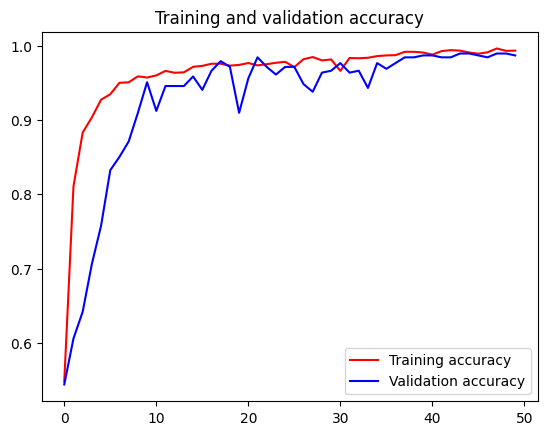

<Figure size 640x480 with 0 Axes>

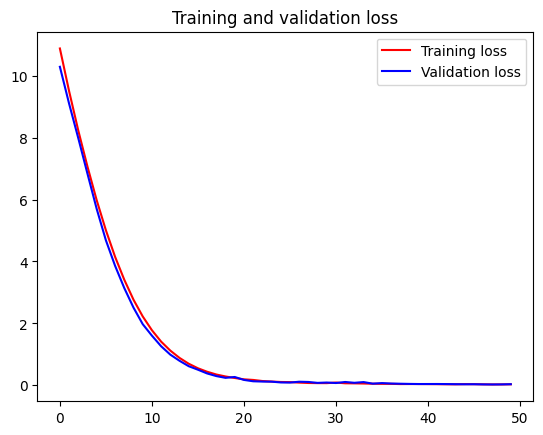

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

### Model Evaluation: Classification Report, Confusion Matrix, and Save Results

This cell evaluates the model's performance on the test set by generating a classification report and confusion matrix. It also saves the results to a file.

#### Classification Report:
- **True Labels and Predicted Labels**:
  - For each batch in the test set (`test_generator`), the true labels (`y_true`) and predicted labels (`y_pred_classes`) are collected.
  - The predictions are generated by the model using `model.predict()`, and the classes with the highest probabilities are selected using `np.argmax()`.

- **Classification Report**:
  - The `classification_report` function from `sklearn` is used to compute various performance metrics, such as precision, recall, F1-score, and accuracy for each class in `SKIN_CLASSES` (the disease classes).
  - The report is printed to show how well the model performs on each class.

#### Confusion Matrix:
- A confusion matrix is computed using `confusion_matrix` from `sklearn` to show the model’s predictions against the true labels.
- The matrix is visualized using a heatmap generated by `seaborn` (`sns.heatmap`), where the x-axis represents predicted classes, and the y-axis represents true classes.
- The confusion matrix is saved as a PNG file (`'confusion_matrix_skindisease.png'`).

#### Saving Evaluation Results:
- The test set's evaluation results (loss and accuracy) are saved into a CSV file (`'evaluation_results_skindisease.csv'`).
- This allows you to keep a record of the model's performance on the test data.

#### Output:
- **Classification Report**: Displays precision, recall, and F1-score for each class.
- **Confusion Matrix**: A heatmap visualizing the true vs. predicted class distributions.
- **Evaluation Results**: The loss and accuracy are saved to a CSV file for further analysis.

This step is essential for assessing how well the model generalizes to the test data and provides insights into areas where the model might need improvement, such as specific disease classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
               precision    recall  f1-score   support

         Acne       1.00      0.97      0.98        62
    Blackhead       0.94      0.98      0.96        63
    Darksspot       1.00      1.00      1.00        67
Enlarged Pore       0.98      0.97      0.98        67
      Redness       1.00      1.00      1.00        66
     Wrinkles       1.00      1.00      1.00        68

     accuracy                           0.99       393
    macro avg       0.99      0.99      0.99 

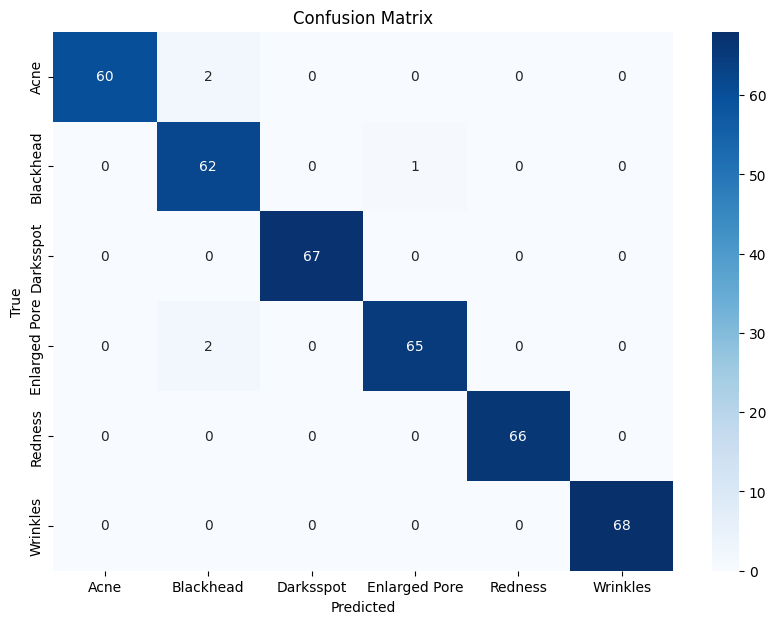

Confusion matrix saved as 'confusion_matrix_skindisease.png'
Evaluation results saved as 'evaluation_results_skindisease.csv'


In [ ]:
SKIN_CLASSES=['Acne', 'Blackhead', 'Darksspot', 'Enlarged Pore', 'Redness', 'Wrinkles']
y_true=[]
y_pred_classes=[]
for i in range(len(test_generator)):
  test_subset = test_generator[i]
  y_true.extend(np.argmax(test_subset[1], axis=1))
  y_pred = model.predict(test_subset[0])
  y_pred_classes.extend(np.argmax(y_pred, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=SKIN_CLASSES))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7 ))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=SKIN_CLASSES, yticklabels=SKIN_CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_skindisease.png')
plt.show()

evaluation_results = model.evaluate(test_generator, verbose=0)
evaluation_df = pd.DataFrame([evaluation_results], columns=['Loss', 'Accuracy'])
evaluation_df.to_csv('evaluation_results_skindisease.csv', index=False)

print("Confusion matrix saved as 'confusion_matrix_skindisease.png'")
print("Evaluation results saved as 'evaluation_results_skindisease.csv'")

### Save Model Summary to a Text File

This cell saves the summary of the model architecture to a text file (`model_summary.txt`) for documentation purposes.

#### Process:
- The `model.summary()` function is called to generate a summary of the model's architecture, including information about the layers, their output shapes, number of parameters, and other details.
- To capture the summary and save it to a file, the standard output (`sys.stdout`) is redirected to the file `model_summary.txt`.
  
#### Error Handling:
- If there is any issue generating the summary (e.g., an exception occurs), it is caught, and an error message is written to the file instead.
- Additionally, if there is an error while saving the summary to the text file (e.g., due to file permission issues), it is caught and displayed.

#### Output:
- The model's architecture summary is saved in `model_summary.txt`.
- If the operation is successful, a message is printed confirming that the summary has been saved.
- In case of errors, appropriate error messages are displayed.

This is useful for saving the model's structure for later reference, sharing, or reviewing the architecture in detail.


In [ ]:
try:
  with open('model_summary.txt', 'w') as m:
    stdout_m = sys.stdout
    sys.stdout = m

    try:
      model.summary()
    except Exception as n:
      print(f"Error while generating summary: {n}")
    finally:
      sys.stdout = stdout_m
  print("Model summary saved in model_summary.txt")
except IOError as n:
  print(f"Error occured when saving model summary: {n}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,078,100 (34.63 MB)

 Trainable params: 3,014,150 (11.50 MB)

 Non-trainable params: 35,648 (139.25 KB)

 Optimizer params: 6,028,302 (23.00 MB)

Model summary saved in model_summary.txt


## Copy Notebook to a Specific Folder

This cell copies the current Jupyter notebook (`SkinIssueModel.ipynb`) to a designated folder on Google Drive for organization or backup purposes.

### Process:
- The notebook file is copied from its current location (`notebook_name`) to a target folder (`folder_path`) using the `cp` command.
- The paths are defined using variables `notebook_name` and `folder_path`, which point to the notebook and the destination folder, respectively.

### Output:
- The notebook file is successfully copied to the specified folder.
- If the copy operation is successful, no additional output is shown, but the notebook is now located in the target folder (`SkinDisease`).

This step is useful for backing up the current notebook, organizing project files, or preparing the notebook for sharing or further work in a specific folder.


In [ ]:
notebook_name = "/content/drive/MyDrive/Colab Notebooks/SkinIssueModel.ipynb"
folder_path = "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease"
!cp "{notebook_name}" "{folder_path}"

## Model Prediction Testing Using Confidence Level

### Load the Model

This cell loads a previously trained model from a saved `.h5` file to continue the evaluation, fine-tuning, or inference process.

#### Process:
- The `tf.keras.models.load_model()` function is used to load the model from the specified file path (`'/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease/model_skin_disease.h5'`).
- The loaded model can then be used for further tasks such as prediction, evaluation, or fine-tuning, without having to retrain it from scratch.

#### Output:
- The model is loaded into memory and is now available for further use. There is no output generated by this operation, but you can interact with the `model` object thereafter (e.g., use it for predictions, evaluation, etc.).

This step is crucial for reusing a trained model that has been saved previously, enabling further testing, deployment, or continued training.


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease/model_skin_disease.h5')

### Preprocess Image and Make Predictions

This cell defines a function for preprocessing an input image, loads the image, preprocesses it for model input, and then makes predictions using a pretrained model.

#### Steps:

1. **Image Preprocessing:**
   - The function `preprocess_image(image_path, target_size)` is defined to load and preprocess an image.
   - The image is resized to the target size (default is 224x224 pixels).
   - The image is converted into a NumPy array using `img_to_array()` and normalized by scaling the pixel values to the range `[0, 1]`.
   - The image array is expanded to include a batch dimension (necessary for model input).

2. **Load and Preprocess the Image:**
   - The function `preprocess_image()` is called with the path to the test image (`image_path`).
   - The image is loaded and processed into the correct format for input to the model.

3. **Prediction:**
   - The processed image is passed to the `model.predict()` method to get the model's predictions.
   - The output predictions contain the confidence levels for each class.

4. **Display Confidence Levels:**
   - The confidence for each class is printed as a percentage.
   - A threshold of 50% is applied to filter out the classes with confidence below the threshold. Only classes with a confidence greater than 50% are displayed.

#### Output:
- The predicted confidence levels for each class are printed in percentage form.
- Classes that have a confidence greater than 50% are listed with their corresponding confidence levels.

This step is essential for performing inference on a new image and displaying the predicted classes with associated confidence scores.


In [ ]:
# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Memuat dan memproses gambar untuk input ke model.
    Args:
    - image_path (str): Path ke gambar.
    - target_size (tuple): Ukuran target untuk gambar.

    Returns:
    - numpy.ndarray: Array gambar yang sudah diproses.
    """
    # Memuat gambar
    img = load_img(image_path, target_size=target_size)
    # Mengubah gambar menjadi array
    img_array = img_to_array(img)
    # Menormalisasi nilai piksel (opsional tergantung preprocessing model)
    img_array = img_array / 255.0
    # Menambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path ke gambar uji
image_path = '/content/14 Fakta Tentang Kucing yang Unik dan Menarik copy - Copy.jpg'

# Preprocess gambar
processed_image = preprocess_image(image_path)

# Prediksi
predictions = model.predict(processed_image)

# Jika Anda memiliki nama kelas
class_names = ['Acne', 'Blackhead', 'Darksspot', 'Enlarged Pore', 'Redness', 'Wrinkles']

# Menampilkan confidence level dalam persentase
for i, class_name in enumerate(class_names):
    confidence = predictions[0][i] * 100  # Konversi ke persentase
    print(f"{class_name}: {confidence:.2f}%")

# Memfilter kelas dengan confidence di atas threshold
threshold = 0.5
predicted_classes = [
    (class_names[i], predictions[0][i] * 100)
    for i in range(len(class_names))
    if predictions[0][i] > threshold
]

print("\nKelas yang terdeteksi (dengan confidence > 50%):")
for class_name, confidence in predicted_classes:
    print(f"{class_name}: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Acne: 2.23%
Blackhead: 96.33%
Darksspot: 1.99%
Enlarged Pore: 0.82%
Redness: 1.12%
Wrinkles: 0.30%

Kelas yang terdeteksi (dengan confidence > 50%):
Blackhead: 96.33%


## Save the Trained Model

This cell saves the trained model to a file for future use, enabling you to reload the model without needing to retrain it.

### Steps:
- The `model.save('model_skin_disease.h5')` function is used to save the entire trained model (architecture, weights, and training configuration) into a file named `model_skin_disease.h5`.
- The saved model can later be loaded using `tf.keras.models.load_model()` to continue from where training left off or for inference purposes.

### Output:
- The model is saved as a `.h5` file, which includes:
  - The architecture of the model.
  - The weights learned during training.
  - The optimizer configuration, if any.
  - The model's state for resuming training or for inference.

This step is crucial for preserving the trained model and reusing it without retraining from scratch.


In [ ]:
model.save('model_skin_disease.h5')

### Copy the Saved Model to Google Drive

This cell copies the saved model (`model_skin_disease.h5`) from the current working directory to a specified folder in Google Drive.

#### Steps:
- The `!cp model_skin_disease.h5 '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease'` command is used to copy the model file.
- The source path is the current directory where the model is saved (`model_skin_disease.h5`).
- The destination path is the specified folder in Google Drive (`/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease`).

#### Output:
- The model file is copied to the designated folder in Google Drive for storage, backup, or sharing purposes.

This step ensures that the trained model is stored in a safe location and can be accessed or reused later from Google Drive.


In [ ]:
!cp model_skin_disease.h5 '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease'

## Convert and Save the Model to TensorFlow Lite Format

This cell performs the following steps:
1. **Load the Saved Model**:
   - The trained model (`model_skin_disease.h5`) is loaded into memory from Google Drive using `tf.keras.models.load_model()`.
   
2. **Convert the Model to TensorFlow Lite Format**:
   - The `TFLiteConverter` is used to convert the Keras model into TensorFlow Lite format. This format is optimized for mobile and embedded device inference.
   - The `converter.convert()` method performs the conversion and outputs the model in `.tflite` format.
   
3. **Save the Converted Model**:
   - The converted TensorFlow Lite model is saved to a `.tflite` file (`model_skin_disease.tflite`) in the current directory.
   
4. **Copy the TensorFlow Lite Model to Google Drive**:
   - The `.tflite` model is then copied to the specified folder in Google Drive for storage and easy access.

#### Steps:
- **Loading**: Load the saved Keras model (`model_skin_disease.h5`).
- **Conversion**: Convert the Keras model to TensorFlow Lite format using `TFLiteConverter`.
- **Saving**: Save the converted model as `model_skin_disease.tflite`.
- **Copying**: Copy the `.tflite` model to Google Drive.

#### Output:
- The model is converted into a more lightweight TensorFlow Lite format and saved for deployment on mobile or embedded devices.
- The `.tflite` model is also backed up in Google Drive for future access.

This step is important for deploying the trained model on devices with limited computational resources, where TensorFlow Lite is designed to provide faster inference with a smaller footprint.

In [ ]:
!cp "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease/model_skin_disease.h5" "/content/model_skin_disease.h5"

In [ ]:
# Load model .h5
model = tf.keras.models.load_model("/content/model_skin_disease.h5")

In [ ]:
# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open("model_skin_disease.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp_v73snmz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137477814414928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814617360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814620880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814411760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814622112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814627216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814624400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814632144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814623344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137477814626160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1374778146307

In [ ]:
!cp "/content/model_skin_disease.tflite" "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease"

### TensorFlow Lite Model Inference

In this cell, the trained TensorFlow Lite model is loaded and used for inference on input data. This is done using the TensorFlow Lite `Interpreter` which allows running the model on devices with limited resources.

#### Steps:
1. **Load the TFLite Model**:
   - The `tf.lite.Interpreter` is initialized with the path to the `.tflite` model (`model_skin_disease.tflite`).
   - The `allocate_tensors()` function is called to allocate memory for the input and output tensors.

2. **Get Input and Output Details**:
   - `input_details` and `output_details` contain the necessary information about the input and output tensors, such as shape, data type, and index.

3. **Prepare Input Data**:
   - In this example, a random input array with shape `(1, 224, 224, 3)` is generated to simulate a single image (with 224x224 size and 3 color channels).
   - Make sure to replace `input_data` with the actual preprocessed input image when performing real inference.

4. **Set Input Tensor**:
   - The input tensor is set by calling `interpreter.set_tensor()` with the input tensor index and the input data.

5. **Run Inference**:
   - `interpreter.invoke()` is used to run the inference on the input data.

6. **Retrieve Output**:
   - After inference, the output tensor is fetched using `interpreter.get_tensor()` to get the predictions from the model.

7. **Output**:
   - The result (`output_data`) is printed. This is the predicted probabilities for each class.

#### Notes:
- Replace the `input_data` with the actual preprocessed image when running on real data.
- This code demonstrates how to load the `.tflite` model and use it for predictions using TensorFlow Lite on a device with limited resources.

### Output:
- **Prediction Results**: The model outputs probabilities for each class. These probabilities indicate the likelihood of the image belonging to each skin disease class.


In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/model_skin_disease.tflite")
interpreter.allocate_tensors()

# Dapatkan informasi tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Contoh input (ganti dengan input sesuai modelmu)
input_data = np.random.rand(1, 224, 224, 3).astype(np.float32)  # Sesuaikan dengan ukuran input modelmu

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Jalankan inferensi
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Hasil prediksi:", output_data)


Hasil prediksi: [[0.02534385 0.9496051  0.01080669 0.00727088 0.01698674 0.00686613]]
